In [5]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 160000
test_portion=.1

corpus = []

In [6]:
num_sentences = 0

with open("training_cleaned.csv", encoding='utf8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        list_item = []
        list_item.append(row[5])
        this_label = row[0]
        
        if this_label == '0':
            list_item.append(0)
        else:
            list_item.append(1)
        
        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [30]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [47]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen = max_length, 
                       padding = padding_type, truncating = trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[split:]
training_sequences = padded[:split]
test_labels = np.array(labels[split:])
training_labels = np.array(labels[:split])

In [48]:
print(vocab_size)
print(word_index['i'])

138590
1


In [49]:
embeddings_index = {};
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [50]:
print(len(embeddings_matrix))

138591


In [51]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, 
                              input_length=max_length, 
                              weights=[embeddings_matrix], 
                              trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, 
                    validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           13859100  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 13,989,021
Trainable params: 129,921
Non-trainable params: 13,859,100
_________________________________________________________________
Train on 16000 samples, validate on 144000 samples
Epoch 1/50
16000/16000 - 81s - loss: 0.6033 - accur

<Figure size 432x288 with 0 Axes>

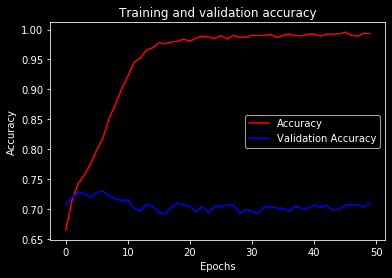

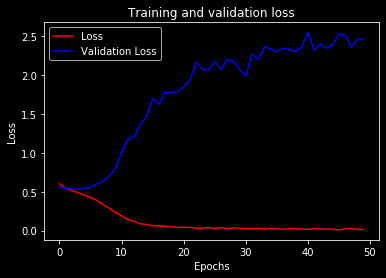

<Figure size 432x288 with 0 Axes>

In [53]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!